In [78]:
import warnings
warnings.filterwarnings('ignore')

%load_ext rpy2.ipython

%run ../notebook-init.py

# load R libraries                                                                                    
%R invisible(library(ggplot2))
%R invisible(library(fastcluster))
%R invisible(library(reshape))
%R invisible(library(reshape2))
%R invisible(library(gplots))
%R invisible(library(RSQLite))

#set up ggplot2 defaults                                                                              
%R theme_set(theme_gray(base_size=18))

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 20)



The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
Populating the interactive namespace from numpy and matplotlib


In [216]:
%%R
as_species <- function(n){
    species <- c(
                    "Cow",
                    "Mouse",
                    "Human",
                    "Sheep",
                    "G. Pig"
                )
    if(n == 'Guinea Pig Stool DNA'){
        return("G. Pig")
    } else if("HMP" %in% strsplit(n," ")[[1]]){
        return("Human")
    }
    for (s in species){
        if( s %in% strsplit(n," ")[[1]]){
            return(s)
        }
    }
        
    if("stool" %in% strsplit(n,"-")[[1]]){
        return("Mouse")
    }
    print(n)
    return(n)
}

prettyname <- function(ugly){
    names = c(
        'gpigfecal.dna', 
        'filtered.stool.day0',  
        'filtered.stool.day14', 
        'rumen.rnalow',         
        'rumen.rnahigh',
        'cowrumen.dna',
        'human.anterior.nares',
        'human.stool',
        'human.posterior.fornix',
        'human.throat',
        'human.qin.CD',
        'human.qin.HEALTHY',
        'human.qin.UC'

    )

    classes = c(
        'Guinea Pig Stool DNA',
        'Healthy Mouse Stool RNA',
        'Colitic Mouse Stool RNA',
        'Sheep Rumen, low-methane prod. RNA',
        'Sheep Rumen, high-methane prod. RNA',
        'Cow Rumen DNA',
        'HMP Anterior Nares DNA',
        'HMP Stool DNA',
        'HMP Posterior Fornix DNA',
        'HMP Throat DNA',
        'CD Human Stool, Qin et al DNA',
        'Healthy Human Stool, Qin et al DNA',
        'UC Human Stool, Qin et al DNA'
    )
    
    ougly <- ugly
    ugly <- strsplit(ugly,c("[\\_\\.\\-]"),fixed=F)[[1]]

    
    i <- 1
    for (name in names){
    
        
        name <- strsplit(name,c("[\\_\\.\\-]"),fixed=F)[[1]]

        if( all(ugly==name)){
            return( classes[i])
        } 
        i <- i+1
    }
    return(ougly)
    
}

print(prettyname("gpigfecal.dna"))
print(prettyname("human.posterior_fornix"))
print(prettyname("cowrumen.dna"))
print(prettyname("human.anterior_nares"))


[1] "Guinea Pig Stool DNA"
[1] "HMP Posterior Fornix DNA"
[1] "Cow Rumen DNA"
[1] "HMP Anterior Nares DNA"


[1] "../taxonomic-profiles/kraken/cow_rumen.species.kraken.aggregated.counts.tsv.gz"  
[2] "../taxonomic-profiles/kraken/g_pig.species.kraken.aggregated.counts.tsv.gz"      
[3] "../taxonomic-profiles/kraken/human_qin.species.kraken.aggregated.counts.tsv.gz"  
[4] "../taxonomic-profiles/kraken/human.species.kraken.aggregated.counts.tsv.gz"      
[5] "../taxonomic-profiles/kraken/mouse.species.kraken.aggregated.counts.tsv.gz"      
[6] "../taxonomic-profiles/kraken/sheep_rumen.species.kraken.aggregated.counts.tsv.gz"
  [1] Cow Rumen DNA                       Cow Rumen DNA                      
  [3] Cow Rumen DNA                       Cow Rumen DNA                      
  [5] Cow Rumen DNA                       Cow Rumen DNA                      
  [7] Cow Rumen DNA                       Cow Rumen DNA                      
  [9] Guinea Pig Stool DNA                Guinea Pig Stool DNA               
 [11] Guinea Pig Stool DNA                Guinea Pig Stool DNA               
 [13] Guin

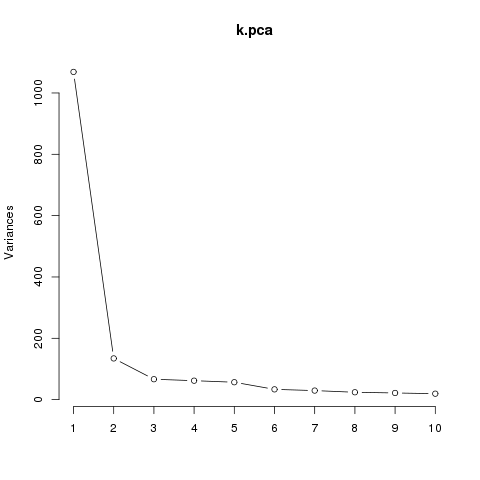

In [197]:
%%R

##########################################################
##########################################################
#
# KRAKEN
#
##########################################################
##########################################################


tableNames <- Sys.glob('../taxonomic-profiles/kraken/*.species.kraken.aggregated.counts.tsv.gz')
print(tableNames)

k.classes <- c()
kraken <- matrix(0,0,0)
k.raw <- matrix(0,0,0)
for (tbl in tableNames){
    tbl <- read.table(tbl,header=T,blank.lines.skip=T,sep="\t",row.names=1)
    classesInTbl <- lapply(colnames(tbl),function(n){prettyname(strsplit(n,'\\.R')[[1]][1])})
    
    tbl[is.na(tbl)] <- 0
    
    k.raw <- merge(k.raw,tbl,by="row.names",all=T)
    k.raw[is.na(k.raw)] <- 0 
    rownames(k.raw) <- k.raw[,1]
    k.raw <- k.raw[,-1]
    
    tbl <- data.matrix(tbl)
    tbl <- sweep(tbl,2,colSums(tbl),function(el,n){ log2(1000000*el/n)})
    tbl <- apply(tbl,1:2,max,0)
    #tbl <- tbl[apply(tbl, 1, function(row) any(row !=0 )),]

    k.classes <- c(k.classes,  unlist(classesInTbl))
    kraken <- merge(kraken,tbl,by="row.names",all=T)
    kraken[is.na(kraken)] <- 0 
    rownames(kraken) <- kraken[,1]
    kraken <- kraken[,-1]
}
k.classes <- as.factor(k.classes)
print(k.classes)
print(kraken[1:2,1:4])
kraken <- kraken[apply(kraken, 1, function(row) any(row !=0 )),]

k.pca <- prcomp(t(kraken),center=T,scale=T)
plot(k.pca,type='l')

[1] "../taxonomic-profiles/ac-diamond-fast/cow_rumen.species.dmndfast.aggregated.counts.tsv.gz"    
[2] "../taxonomic-profiles/ac-diamond-fast/g_pig.species.acdmndfast.aggregated.counts.tsv.gz"      
[3] "../taxonomic-profiles/ac-diamond-fast/hmp.species.acdmndfast.aggregated.counts.tsv.gz"        
[4] "../taxonomic-profiles/ac-diamond-fast/human_qin.species.acdmndfast.aggregated.counts.tsv.gz"  
[5] "../taxonomic-profiles/ac-diamond-fast/mouse.species.acdmndfast.aggregated.counts.tsv.gz"      
[6] "../taxonomic-profiles/ac-diamond-fast/sheep_rumen.species.acdmndfast.aggregated.counts.tsv.gz"
[1] "../taxonomic-profiles/ac-diamond-fast/cow_rumen.species.dmndfast.aggregated.counts.tsv.gz"
[1] "../taxonomic-profiles/ac-diamond-fast/g_pig.species.acdmndfast.aggregated.counts.tsv.gz"
[1] "../taxonomic-profiles/ac-diamond-fast/hmp.species.acdmndfast.aggregated.counts.tsv.gz"
[1] "../taxonomic-profiles/ac-diamond-fast/human_qin.species.acdmndfast.aggregated.counts.tsv.gz"
[1] "../taxonomic-pr

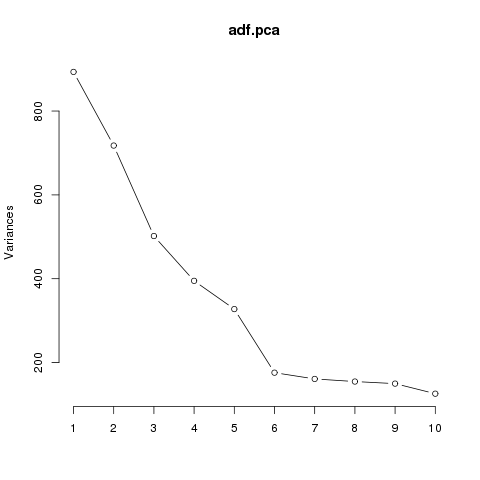

In [199]:

%%R

##########################################################
##########################################################
#
# AC-DIAMOND FAST
#
##########################################################
##########################################################

tableNames <- Sys.glob('../taxonomic-profiles/ac-diamond-fast/*.species.*dmndfast.aggregated.counts.tsv.gz')
print(tableNames)

adf.classes <- c()
acdmndfast <- matrix(0,0,0)
adf.raw <- matrix(0,0,0)
for (tbl in tableNames){
    print(tbl)
    tbl <- read.table(tbl,header=T,blank.lines.skip=T,sep="\t",row.names=1)
    classesInTbl <- lapply(colnames(tbl),function(n){prettyname(strsplit(n,'\\.R')[[1]][1])})

    adf.raw <- merge(adf.raw,tbl,by="row.names",all=T)
    adf.raw[is.na(adf.raw)] <- 0 
    rownames(adf.raw) <- adf.raw[,1]
    adf.raw <- adf.raw[,-1]
    
    tbl[is.na(tbl)] <- 0
    tbl <- data.matrix(tbl)
    tbl <- sweep(tbl,2,colSums(tbl),function(el,n){ log2(1000000*el/n)})
    tbl <- apply(tbl,1:2,max,0)
    #tbl <- tbl[apply(tbl, 1, function(row) any(row !=0 )),]

    adf.classes <- c(adf.classes,  unlist(classesInTbl))
    acdmndfast <- merge(acdmndfast,tbl,by="row.names",all=T)
    acdmndfast[is.na(acdmndfast)] <- 0 

    rownames(acdmndfast) <- acdmndfast[,1]
    acdmndfast <- acdmndfast[,-1]
}
adf.classes <- factor(adf.classes)
print(adf.classes)
acdmndfast <- acdmndfast[apply(acdmndfast, 1, function(row) any(row !=0 )),]  
    
print(length(adf.classes))
print(dim(acdmndfast))
print(acdmndfast[1:5,1:4])
            

adf.pca <- prcomp(t(acdmndfast),center=T,scale=T)
plot(adf.pca,type='l')                    


  [1] Cow Rumen DNA                       Cow Rumen DNA                      
  [3] Cow Rumen DNA                       Cow Rumen DNA                      
  [5] Cow Rumen DNA                       Cow Rumen DNA                      
  [7] Cow Rumen DNA                       Cow Rumen DNA                      
  [9] Guinea Pig Stool DNA                Guinea Pig Stool DNA               
 [11] Guinea Pig Stool DNA                Guinea Pig Stool DNA               
 [13] Guinea Pig Stool DNA                Guinea Pig Stool DNA               
 [15] Guinea Pig Stool DNA                Guinea Pig Stool DNA               
 [17] HMP Anterior Nares DNA              HMP Anterior Nares DNA             
 [19] HMP Anterior Nares DNA              HMP Anterior Nares DNA             
 [21] HMP Anterior Nares DNA              HMP Anterior Nares DNA             
 [23] HMP Anterior Nares DNA              HMP Anterior Nares DNA             
 [25] HMP Anterior Nares DNA              HMP Anterior Nares DNA

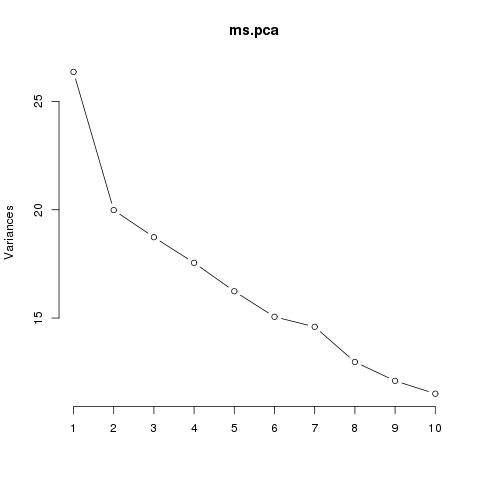

In [246]:
%%R

##########################################################
##########################################################
#
# METAPHLAN2 SPECIES
#
##########################################################
##########################################################

tableNames <- Sys.glob('../taxonomic-profiles/metaphlan/*.mp2prof.tsv')

ms.classes <- c()
ms <- matrix(0,0,0)

getTable <- function(tblName){
    out <- tryCatch(
        {
            tbl <- read.table(tblName,blank.lines.skip=T,sep="\t",row.names=1)
            return(tbl)
        },
        error=function(cond){
            return(matrix(0,0,1))
        },
        warning=function(cond){
            return(matrix(0,0,1))
        },
        finally={
            
        }
    )
    return(out)
}


for (tblName in tableNames){
#     print(tblName)
    tbl <- getTable(tblName)
#     if(!tbl){
#         next
#     }

    class <- tail(strsplit(strsplit(tblName,'-R')[[1]][1],'/')[[1]],1)
    class <- tail(strsplit(class,'\\.')[[1]],1)
    class <- prettyname(class)
    sample <- tail(strsplit(strsplit(tblName,'\\.mp2')[[1]][1],'/')[[1]],1)
    sp <- rownames(tbl)[grep('s__',rownames(tbl))]
    sp <- sp[grep('t__',genera,invert=T)]

    tbl <-tbl[rownames(tbl) %in% sp,,drop=F]
    ms.classes <- c(ms.classes,class)
    newcolnames <- c(colnames(ms),sample)
    ms <- merge(ms,tbl,by="row.names",all=T)
    ms[is.na(ms)] <- 0
    rownames(ms) <- ms[,1]
    ms <- ms[,-1,drop=F]
    colnames(ms) <- newcolnames
}
ms.classes <- factor(ms.classes)
print(ms.classes)
print(ms[1:5,1:4])

ms.pca <- prcomp(t(ms),center=T,scale=T)
plot(ms.pca,type='l')





[1] "../taxonomic-profiles/metaphlan/cow_rumen.cowrumen-dna-R983262.mp2prof.tsv"
[1] "../taxonomic-profiles/metaphlan/cow_rumen.cowrumen-dna-R983263.mp2prof.tsv"
[1] "../taxonomic-profiles/metaphlan/cow_rumen.cowrumen-dna-R983264.mp2prof.tsv"
[1] "../taxonomic-profiles/metaphlan/cow_rumen.cowrumen-dna-R983265.mp2prof.tsv"
[1] "../taxonomic-profiles/metaphlan/cow_rumen.cowrumen-dna-R983266.mp2prof.tsv"
[1] "../taxonomic-profiles/metaphlan/cow_rumen.cowrumen-dna-R983267.mp2prof.tsv"
[1] "../taxonomic-profiles/metaphlan/cow_rumen.cowrumen-dna-R983268.mp2prof.tsv"
[1] "../taxonomic-profiles/metaphlan/cow_rumen.cowrumen-dna-R983269.mp2prof.tsv"
[1] "../taxonomic-profiles/metaphlan/g_pig.gpigfecal-dna-R495409.mp2prof.tsv"
[1] "../taxonomic-profiles/metaphlan/g_pig.gpigfecal-dna-R496625.mp2prof.tsv"
[1] "../taxonomic-profiles/metaphlan/g_pig.gpigfecal-dna-R496626.mp2prof.tsv"
[1] "../taxonomic-profiles/metaphlan/g_pig.gpigfecal-dna-R496699.mp2prof.tsv"
[1] "../taxonomic-profiles/metaphlan/g_p

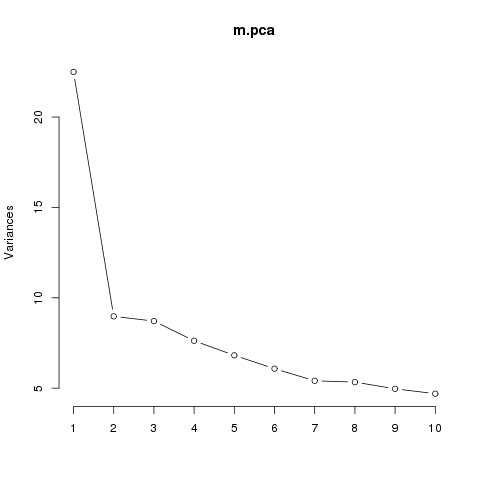

In [361]:
%%R

##########################################################
##########################################################
#
# METAPHLAN2
#
##########################################################
##########################################################

tableNames <- Sys.glob('../taxonomic-profiles/metaphlan/*.mp2prof.tsv')

m.classes <- c()
mphlan <- matrix(0,0,0)

getTable <- function(tblName){
    out <- tryCatch(
        {
            tbl <- read.table(tblName,blank.lines.skip=T,sep="\t",row.names=1)
            return(tbl)
        },
        error=function(cond){
            return(FALSE)
        },
        warning=function(cond){
            return(FALSE)
        },
        finally={
            
        }
    )
    return(out)
}


for (tblName in tableNames){
    print(tblName)
    tbl <- getTable(tblName)
    if(!tbl){
        next
    }

    class <- tail(strsplit(strsplit(tblName,'-R')[[1]][1],'/')[[1]],1)
    class <- tail(strsplit(class,'\\.')[[1]],1)
    class <- prettyname(class)
    sample <- tail(strsplit(strsplit(tblName,'\\.mp2')[[1]][1],'/')[[1]],1)
    genera <- rownames(tbl)[grep('g__',rownames(tbl))]
    genera <- genera[grep('s__',genera,invert=T)]
    tbl <-tbl[rownames(tbl) %in% genera,,drop=F]
    m.classes <- c(m.classes,class)
    newcolnames <- c(colnames(mphlan),sample)
    mphlan <- merge(mphlan,tbl,by="row.names",all=T)
    mphlan[is.na(mphlan)] <- 0
    rownames(mphlan) <- mphlan[,1]
    mphlan <- mphlan[,-1,drop=F]
    colnames(mphlan) <- newcolnames
}
m.classes <- factor(m.classes)
print(m.classes)
print(mphlan[1:5,1:4])

m.pca <- prcomp(t(mphlan),center=T,scale=T)
plot(m.pca,type='l')





In [321]:
%%R

##########################################################
##########################################################
#
# ICA Plots
#
##########################################################
##########################################################

library(ggplot2)
library(gridExtra)
library(factoextra)
library(vegan)


plotICA <- function(ica, classes){
    
    df <- data.frame(ica$S)
    df['Groups'] = classes
    combs <- combn(1:dim(ica$S)[2],2,simplify=F)
    for (comb in combs){
        X = colnames(df)[comb[1]]
        Y = colnames(df)[comb[2]]
        p <- ggplot(df,aes_string(x=X,y=Y, color="Groups")) +
                geom_point(size=4) +
                stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="Groups")) +
                theme_minimal()
        print(p)
    }
    
    
}


In [394]:
%%R

##########################################################
##########################################################
#
# PCA Plots
#
##########################################################
##########################################################

library(ggplot2)
library(gridExtra)
library(factoextra)
library(vegan)



plotPCA <- function(comps, pca, classes){
        species <- as.factor(unlist(lapply(as.character(classes),FUN=as_species)))
        df <- data.frame(pca$x)
        df['Groups'] = classes
        df['Species'] = species
        combs <- combn(comps,2,simplify=F)
        for (comb in combs){
            X = colnames(df)[comb[1]]
            Y = colnames(df)[comb[2]]
            p <- ggplot(df,aes_string(x=X,y=Y, color="Species",shape="Species")) +
                    geom_point(size=8) +
                    #scale_shape_manual(values=c(3,16,17)) +
                    stat_ellipse(geom = "polygon", alpha = 1/10,aes_string(fill="Species")) +
                    theme_minimal()
            print(p)
        }
    
        ad <- adonis(pca$x[,1:2] ~ Species,data=df,method='bray')

    return(ad)
}



Call:
adonis(formula = pca$x[, 1:2] ~ Species, data = df, method = "bray") 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Species     4   291.897  72.974   66061 0.99963  0.001 ***
Residuals  97     0.107   0.001         0.00037           
Total     101   292.004                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Call:
adonis(formula = pca$x[, 1:2] ~ Species, data = df, method = "bray") 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Species     4   291.897  72.974   66061 0.99963  0.001 ***
Residuals  97     0.107   0.001         0.00037           
Total     101   292.004                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


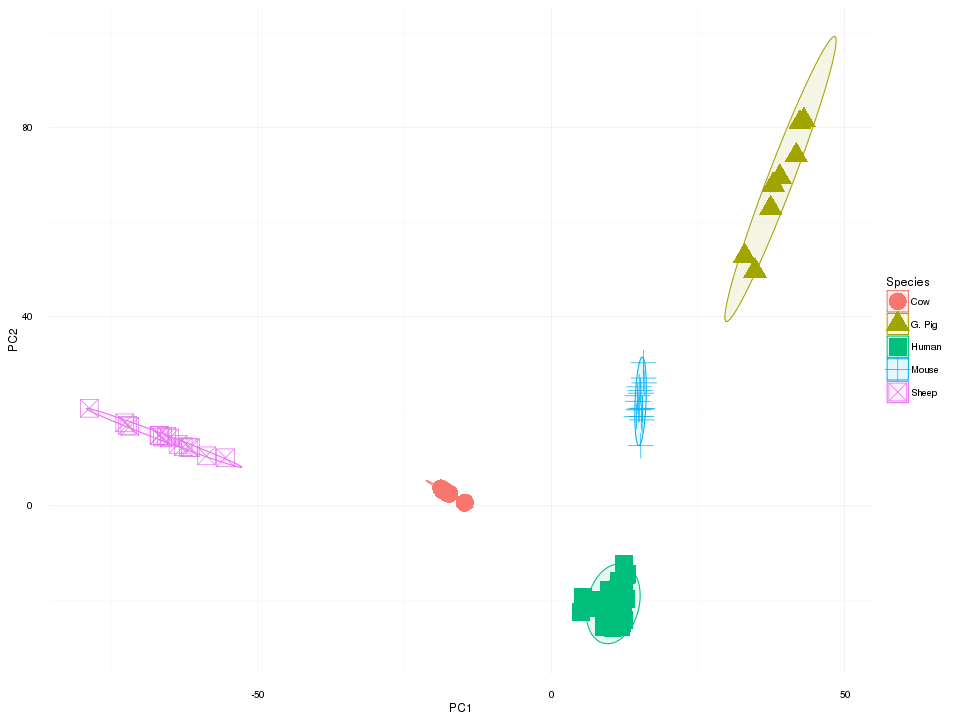

In [399]:
%%R -w 960 -h 720 -u px


ad <- plotPCA(1:2, adf.pca, adf.classes)
ad

In [400]:
%%R

summary(ad)


             Length Class  Mode   
aov.tab        6    anova  list   
call           4    -none- call   
coefficients  10    -none- numeric
coef.sites   510    -none- numeric
f.perms      999    -none- numeric
model.matrix 510    -none- numeric
terms          3    terms  call   



Call:
adonis(formula = pca$x[, 1:2] ~ Species, data = df, method = "bray") 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Species     4    49.510 12.3775   42876 0.99943  0.001 ***
Residuals  97     0.028  0.0003         0.00057           
Total     101    49.538                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Call:
adonis(formula = pca$x[, 1:2] ~ Species, data = df, method = "bray") 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

           Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)    
Species     4    49.510 12.3775   42876 0.99943  0.001 ***
Residuals  97     0.028  0.0003         0.00057           
Total     101    49.538                 1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


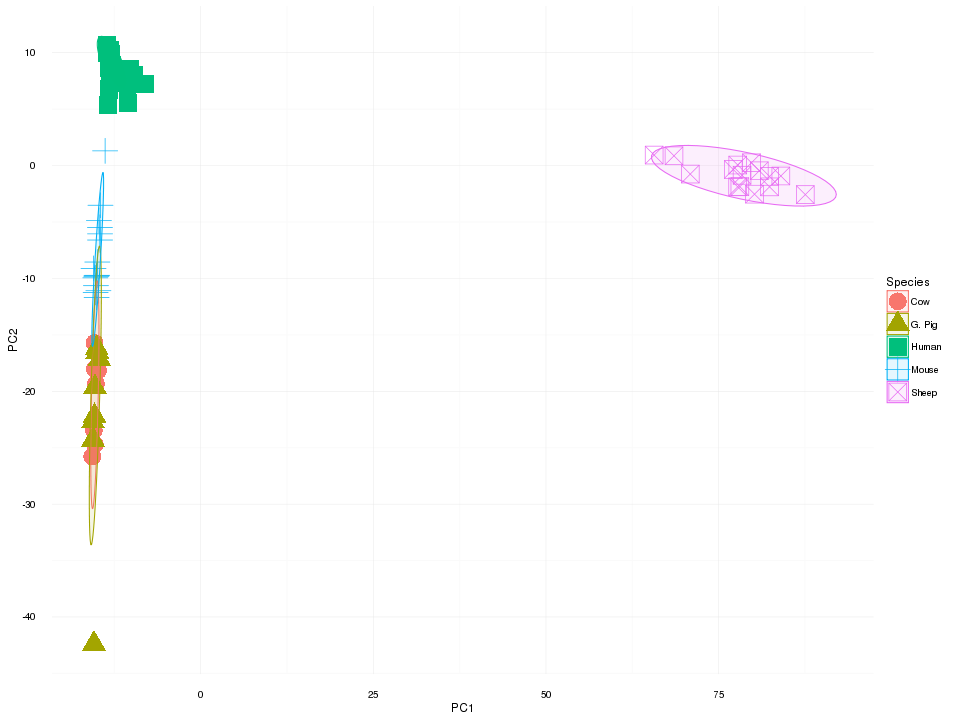

In [401]:
%%R -w 960 -h 720 -u px
plotPCA(1:2, k.pca, k.classes)


Call:
adonis(formula = pca$x[, 1:2] ~ Species, data = df, method = "bray") 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model     R2 Pr(>F)
Species    4    3682.4  920.60  21.742 0.4999  0.324
Residuals 87    3683.8   42.34         0.5001       
Total     91    7366.2                 1.0000       

Call:
adonis(formula = pca$x[, 1:2] ~ Species, data = df, method = "bray") 

Permutation: free
Number of permutations: 999

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model     R2 Pr(>F)
Species    4    3682.4  920.60  21.742 0.4999  0.324
Residuals 87    3683.8   42.34         0.5001       
Total     91    7366.2                 1.0000       


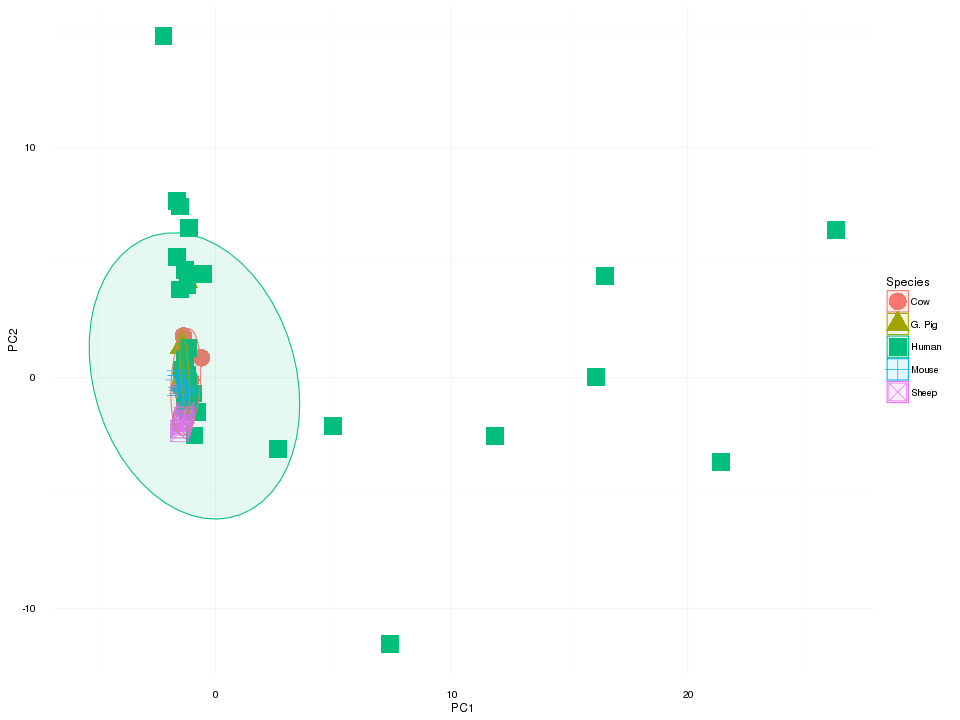

In [402]:
%%R -w 960 -h 720 -u px

plotPCA(1:2, m.pca, m.classes)

In [208]:
%%R


make_jsd_matrix <- function(n){

    m <- matrix(nrow=ncol(n),ncol=ncol(n))

    for (i in 1:ncol(n)){
        for (j in 1:ncol(n)){
            m[i,j] <- jsd(n[,i],n[,j])
        }
     }
    colnames(m) <- colnames(n)
     rownames(m) <- colnames(n)
     return(m)
}

jsd <- function(a,b){
    anorm <- a/sum(a)
    bnorm <- b/sum(b)
     m <- (anorm+bnorm)/2
     div <- kld(anorm,m)/2 + kld(bnorm,m)/2
     dist <- sqrt(div)
     return(dist) 
}

kld <- function(a,b){
     l <- log(a/b, 2)
     l[is.na(l)] <- 0
     l[is.infinite(l)] <- 0

    return( sum( a * l))
}

make_cos_matrix <- function(n){

    m <- matrix(nrow=ncol(n),ncol=ncol(n))

    for (i in 1:ncol(n)){
        for (j in 1:ncol(n)){
            m[i,j] <- cos(n[,i],n[,j])
        }
     }
    colnames(m) <- colnames(n)
     rownames(m) <- colnames(n)
     return(m)
}

cos <- function(a,b){
    dprod <- a %*% b
    magprod <- sqrt(sum(a %*% a)) * sqrt(sum(b %*% b))
    
     return(1 - (dprod/magprod)) 
}



In [405]:
%%R

library(devtools)
library(reshape2)
library(Heatplus)
library(RColorBrewer)
library(gplots)
source('../custom-code/heatmap.3.by-obi-griffith.R')


gut_only<- function(v){

    
    v. <- lapply(v,FUN=function(el){
            el <- as.character(el)
            o <- grep('posterior',el,invert=TRUE,fixed=TRUE,ignore.case=TRUE) & 
            grep('anterior',el,invert=TRUE,fixed=TRUE,ignore.case=TRUE) & 
            grep('throat',el,invert=TRUE,fixed=TRUE,ignore.case=TRUE)
            return(o)
    })
    v. <- unlist(v.)
    print(v)
    print(v.)
    return(v.)
    
}

in_class <- function(m,classes){
    n <- c() 
    for (c in unique(classes)){
        n <- c(n, mean(m[classes == c, classes == c]))
    }
    return( mean(n))
}

out_class <- function(m,classes){
    n <- c() 
    for (c in unique(classes)){
        n <- c(n, mean(m[classes == c, classes != c]))
    }
    return( mean(n))
}


my_plot_heatmap <- function(m,classes){
    


    cCols <- rainbow(length(unique(classes)),s=0.4)[unclass(classes)]
    species <- as.factor(unlist(lapply(as.character(classes),FUN=as_species)))
    sCols <- rainbow(length(unique(species)))[unclass(species)]
    
    i <- in_class(m,species)
    o <- out_class(m,species)
    print(i/o)
    
    sideCols <- cbind(cCols,sCols)
    colnames(sideCols) <- c("Experiment", "Species")
        mydist=function(c) {dist(c,method="euclidian")}
        myclust=function(c) {hclust(c,method="average")}
        heatmap.3(m,
                    hclustfun=myclust,
                    distfun=mydist,
                    ColSideColors=as.matrix(sCols),
                      ColSideColorsSize=3,
                    nrow=2,
                    labRow=FALSE,
                    labCol=FALSE,
                    margins=c(6,12),
                    key=FALSE,
                    dendrogram="row"
                    )

            legend("topleft",
               ncol=2,
               legend=as.character(unique(species)),
               fill=unique(sCols),
               border=FALSE,
               bty="n",
               cex=1,
               y.intersp=0.7,
              )

}



[1] 0.3114924
[1] 0.1353756


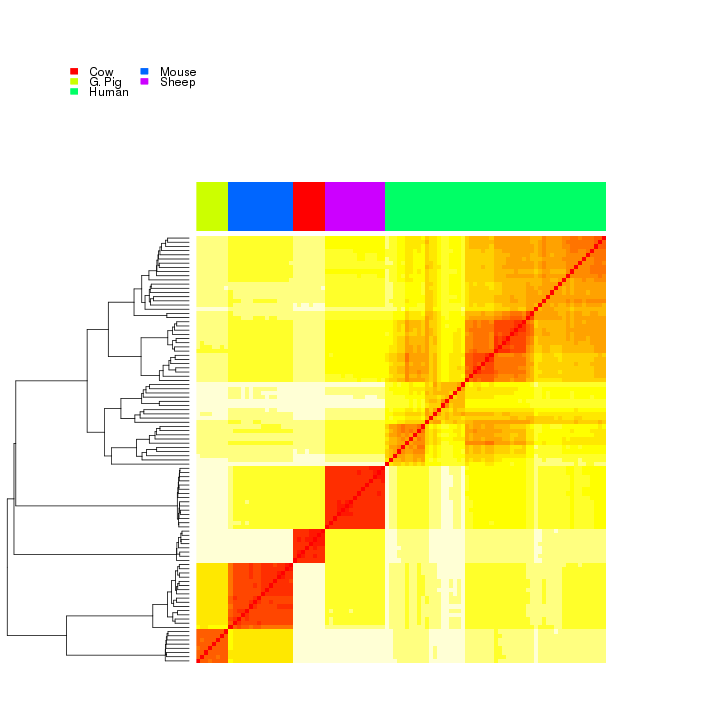

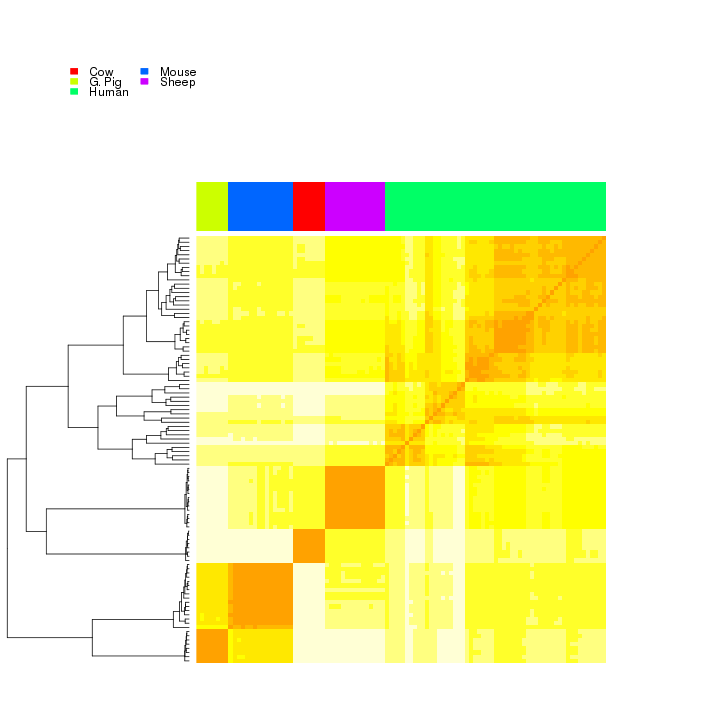

In [406]:
%%R -w 720 -h 720 -u px

adf.jdm <- make_jsd_matrix(acdmndfast)
my_plot_heatmap(adf.jdm, adf.classes)

adf.cos <- make_cos_matrix(acdmndfast)
my_plot_heatmap(adf.cos, adf.classes)


[1] 0.4387092
[1] 0.3130013


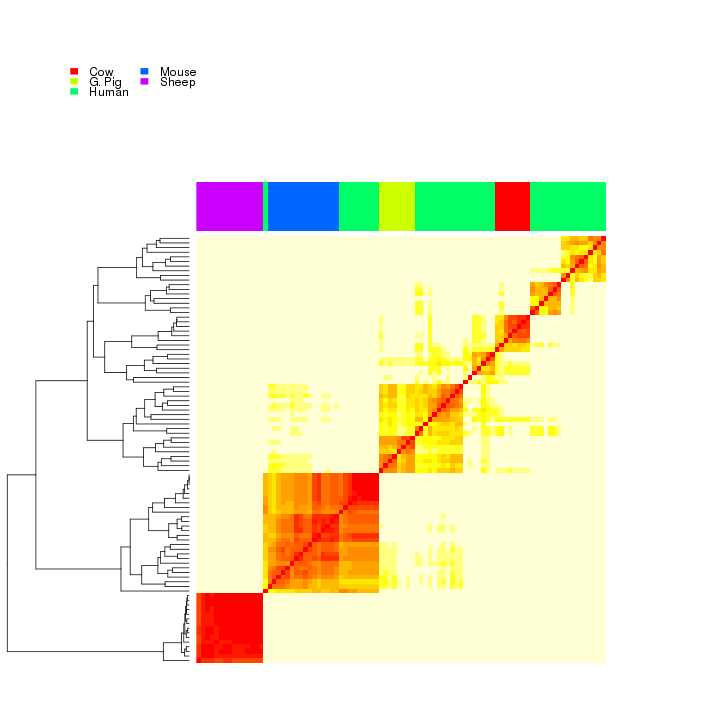

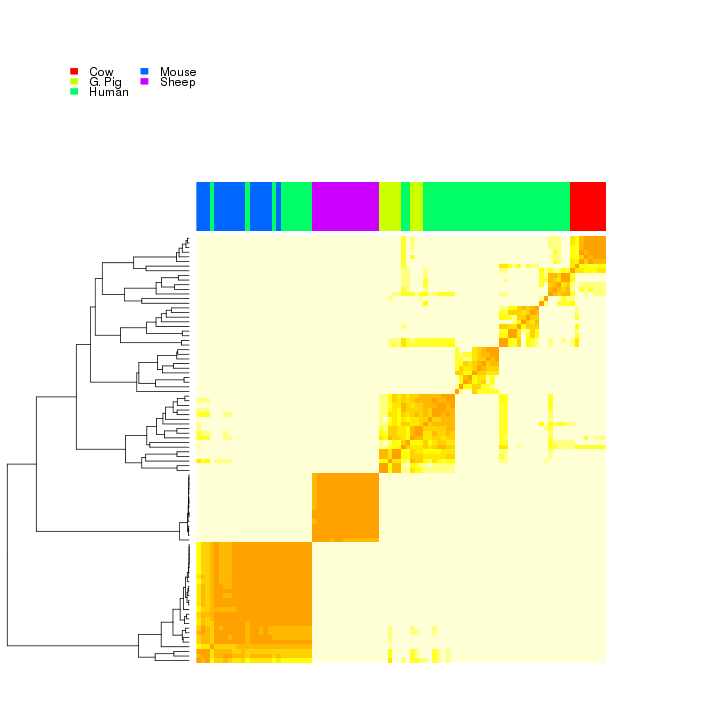

In [407]:
%%R -w 720 -h 720 -u px

m.jdm <- make_jsd_matrix(mphlan)
my_plot_heatmap(m.jdm,m.classes)

m.cos <- make_cos_matrix(mphlan)
my_plot_heatmap(m.cos,m.classes)

[1] 0.4642256
[1] 0.2884879


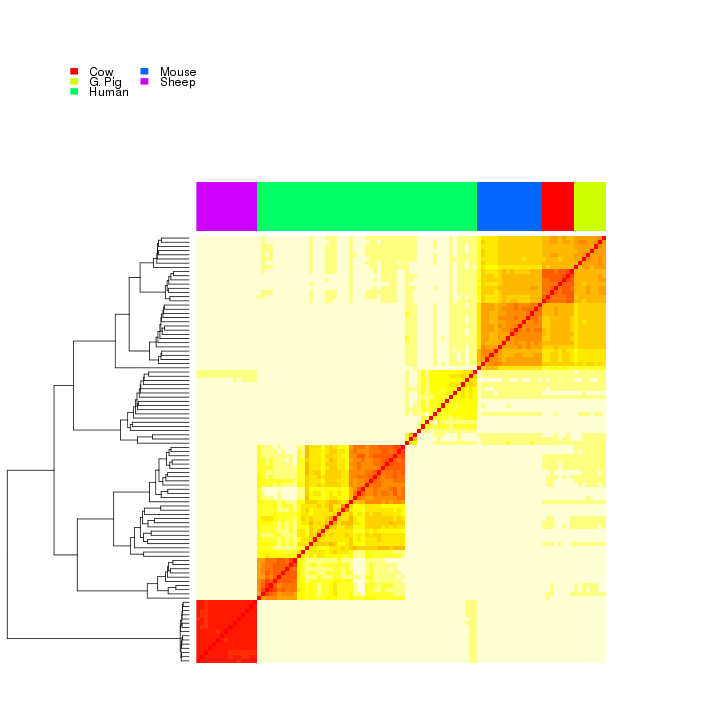

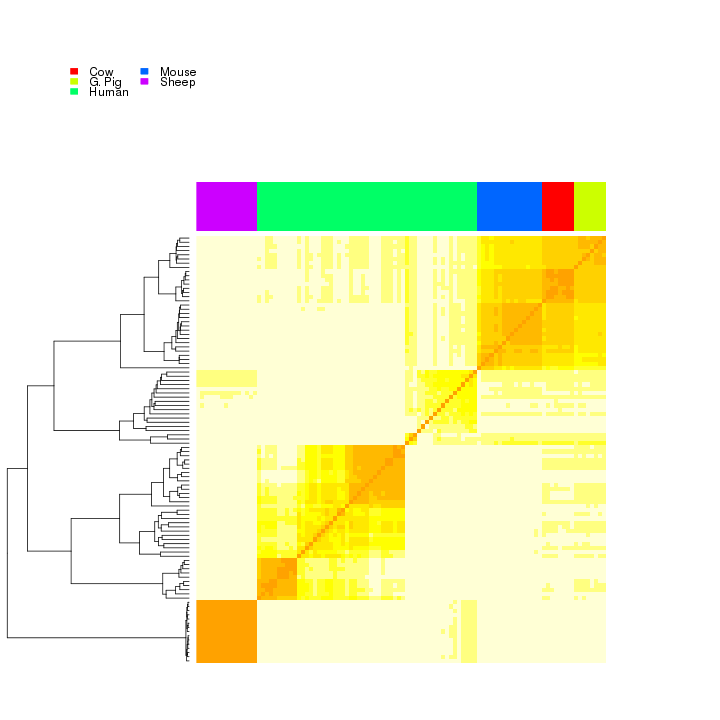

In [408]:
%%R -w 720 -h 720 -u px

k.jdm <- make_jsd_matrix(kraken)
my_plot_heatmap(k.jdm,k.classes)

k.cos <- make_cos_matrix(kraken)
my_plot_heatmap(k.cos,k.classes)

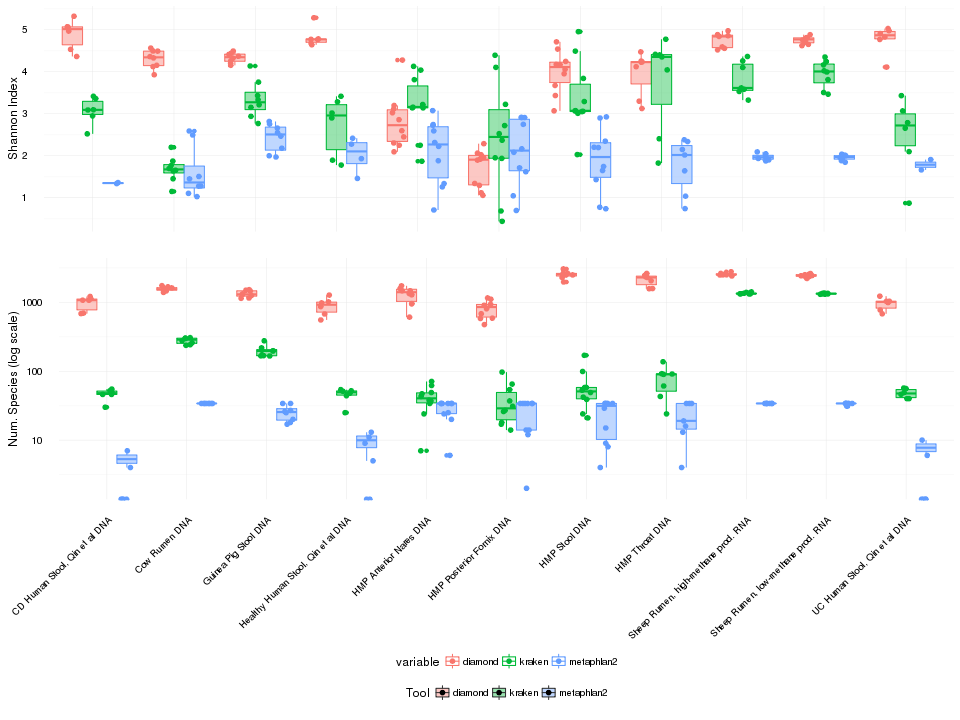

In [325]:
%%R -w 960 -h 720 -u px
dim(k.raw)

#########################################################################################
#########################################################################################
#
# Richness Figure
#
#########################################################################################
#########################################################################################

getrichness <- function(vec){
   return(sum(vec!=0)) 
}

getshannon <- function(vec){
    colsum = sum(vec)
    ps <- lapply(vec,FUN=function(el){
        p = 0.0000001 + el / colsum
        return( p * log(p))
    })
    ps <- unlist(ps)
    return(-sum(ps))
}

getsimpson <- function(vec){
    colsum = sum(vec)
    ps <- lapply(vec,FUN=function(el){
        p = 0.0000001 + el / colsum
        return( p * p)
    })
    ps <- unlist(ps)
    return(1-sum(ps))
}

k.richness <- apply(k.raw,2,getrichness)
adf.richness <- apply(adf.raw,2,getrichness)
ms.richness <- apply(ms,2,getrichness)
# print(dim(k.raw))
# print(colnames(k.raw))
# print(length(k.richness))
# print(dim(adf.raw))
# print(length(adf.richness))
# print(dim(ms))
# print(length(ms.richness))



k.shannon <- apply(k.raw,2,getshannon)
adf.shannon <- apply(adf.raw,2,getshannon)
ms.shannon <- apply(ms,2,getshannon)
adf.shannon.limited <- apply(adf.raw[rownames(adf.raw) %in% rownames(k.raw),],2,getshannon)

k.simpson <- apply(k.raw,2,getsimpson)
adf.simpson <- apply(adf.raw,2,getsimpson)

my_boxplot <- function(stat, groups){
    o <- order(richness)
    rtable <- data.frame(x=stat[o], grp=groups[o])
#     print(head(rtable))
    ggplot(rtable,aes(x=grp,y=x,color=grp)) + 
        geom_point() +
        geom_boxplot() +
        geom_jitter() +
        scale_y_log10()+
        theme_minimal() +
        theme(axis.text.x = element_blank(),legend.position="bottom")
}

#print(my_boxplot(k.richness,k.classes))
#print(my_boxplot(adf.richness,adf.classes))

shared.classes <- intersect(unique(ms.classes), intersect( unique(adf.classes), unique(k.classes)))
k.richness.shared <- k.richness[k.classes %in% shared.classes]
adf.richness.shared <- adf.richness[adf.classes %in% shared.classes]
ms.richness.shared <- ms.richness[ms.classes %in% shared.classes]
shared.classes <- adf.classes[adf.classes %in% shared.classes]
rtable <- data.frame(
                        group=shared.classes, 
                        diamond=adf.richness.shared, 
                        kraken=k.richness.shared,
                        metaphlan2=ms.richness.shared
                    )
rtable <- melt(rtable,id.vars=1)
rplot <- ggplot(rtable,aes(x=group,y=value,fill=variable,color=variable)) + 
        geom_boxplot(alpha=0.4) +
        geom_point(position=position_jitterdodge(),size=2) +
        scale_y_log10()+
        theme_minimal() +
        ylab("Num. Species (log scale)") +
        theme(axis.text.x = element_text(angle = 45, hjust = 1),axis.title.x=element_blank(),legend.position="bottom") +
        scale_fill_discrete("Tool")

shared.classes <- intersect( unique(ms.classes), intersect( unique(adf.classes), unique(k.classes)))
k.shannon.shared <- k.shannon[k.classes %in% shared.classes]
adf.shannon.shared <- adf.shannon[adf.classes %in% shared.classes]
ms.shannon.shared <- ms.shannon[ms.classes %in% shared.classes]
adf.shannon.limited.shared <- adf.shannon.limited[adf.classes %in% shared.classes]
shared.classes <- adf.classes[adf.classes %in% shared.classes]
#rtable <- data.frame(group=shared.classes, diamond=adf.shannon.shared, diamond.limited=adf.shannon.limited.shared, kraken=k.shannon.shared)
rtable <- data.frame(
                        group=shared.classes,
                        diamond=adf.shannon.shared,
                        kraken=k.shannon.shared,
                        metaphlan2=ms.shannon.shared
                    )
rtable <- melt(rtable,id.vars=1)
splot <- ggplot(rtable,aes(x=group,y=value,fill=variable,color=variable)) + 
        geom_boxplot(alpha=0.4) +
        geom_point(position=position_jitterdodge(),size=2) +
        theme_minimal() +
        ylab("Shannon Index") + 
        theme(axis.text.x =element_blank(),axis.title.x=element_blank(), legend.position="none")

# shared.classes <- intersect( unique(adf.classes), unique(k.classes))
# k.simpson.shared <- k.simpson[k.classes %in% shared.classes]
# adf.simpson.shared <- adf.simpson[adf.classes %in% shared.classes]
# shared.classes <- adf.classes[adf.classes %in% shared.classes]
# rtable <- data.frame(group=shared.classes, diamond=adf.simpson.shared, kraken=k.simpson.shared)
# rtable <- melt(rtable,id.vars=1)
# homerplot <- ggplot(rtable,aes(x=group,y=value,fill=variable)) + 
#         geom_boxplot(alpha=0.4) +
#         geom_point(position=position_jitterdodge(),size=2) +
#         theme_minimal() +
#         ylab("Gini-Simpson Index") + 
#         theme(axis.text.x =element_blank(),axis.title.x=element_blank(), legend.position="none") +
#         scale_fill_discrete("Tool")

#print(splot)
#print(homerplot)
#print(rplot)

grid.arrange(splot,rplot,ncol=1, heights=c(0.35,0.65))


[1] 2754   10


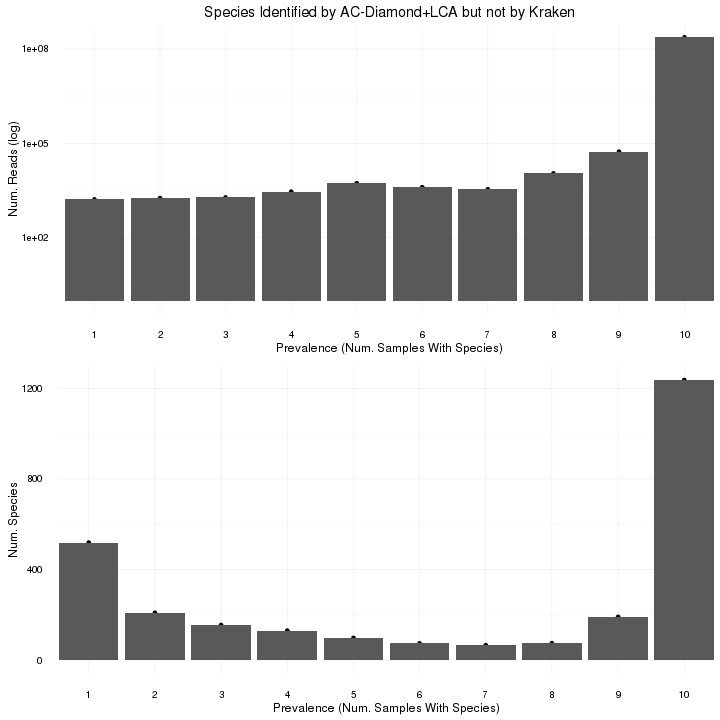

In [311]:
%%R -w 720 -h 720

hstool <- adf.raw[,grep('human.stool',colnames(adf.raw))]
hstool <- hstool[apply(hstool, 1, function(row) any(row !=0 )),]
hstool <- hstool[!(rownames(hstool) %in% rownames(k.raw)),]
print(dim(hstool))
    
unweighted <- apply(hstool, 1, function(row) sum(row !=0 ))
weighted <- apply(hstool, 1, function(row) sum(row))


wdf <- data.frame(
        unweighted,
        weighted
        )

    
w <- c()
u <- c()
for (i in 1:10){
    s1 <- sum(wdf[wdf$unweighted == i,])
    s2 <- sum(wdf$unweighted == i)
    w <- c(w,s1)
    u <- c(u,s2)
}

wplot <- qplot(1:10,w)+
                geom_bar(stat='identity')+
                scale_y_log10()+
                theme_minimal()+
                labs(x='Prevalence (Num. Samples With Species)',y='Num. Reads (log)')+
                ggtitle("Species Identified by AC-Diamond+LCA but not by Kraken")+
                scale_x_discrete(limits=1:10)
    
uplot <- qplot(1:10,u)+
                geom_bar(stat='identity')+
                theme_minimal()+
                labs(x='Prevalence (Num. Samples With Species)',y='Num. Species')+
                scale_x_discrete(limits=1:10)
    
    
grid.arrange(wplot,uplot,ncol=1)   
    
    